# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy, tqdm

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import silence_tensorflow
silence_tensorflow

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing, custom_metrics

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
# EXP_NAME_VEC = ('exp0','exp1','exp2','exp3', 'exp4','exp5','exp6','exp7')
# PLOT_SEED = 1257
EXP_NAME_VEC = ('exp10',)
PLOT_SEED = 1257

#-------------------------------------------------------

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Plotting Functions

In [4]:
FS = 10

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Analyze CMIP results across random seeds

In [5]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_VEC:
    settings = experiment_settings.get_settings(exp_name)
    rng = np.random.default_rng(settings["rng_seed"])    
    print(exp_name)


    for iloop in np.arange(settings['n_models']):
        seed = rng.integers(low=1_000,high=10_000,size=1)[0]
        settings["seed"] = int(seed)
        tf.random.set_seed(settings["seed"])
        np.random.seed(settings["seed"])

        # get model name
        model_name = file_methods.get_model_name(settings)
        if os.path.exists(MODEL_DIRECTORY + model_name + "_model") == False:
            continue
        model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)
        # get the data
        (x_train, 
         x_val, 
         x_test, 
         y_train, 
         y_val, 
         y_test, 
         onehot_train, 
         onehot_val, 
         onehot_test, 
         y_yrs_train, 
         y_yrs_val, 
         y_yrs_test, 
         target_years, 
         map_shape,
         settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)

        #----------------------------------------        
        # make predictions for observations and cmip results
        pred_train = model.predict(x_train)
        pred_val = model.predict(x_val)
        pred_test = model.predict(x_test) 

        #----------------------------------------  
        # plot PIT histogram
        if settings["seed"] == PLOT_SEED:
            fig, ax = plt.subplots(1,1)
            plots.plot_pits(ax, x_val=x_val, onehot_val=onehot_val,  model_shash = model)
            format_spines(plt.gca())
            plt.savefig(FIGURE_DIRECTORY + model_name + '_pit' + '.png', 
                        bbox_inches="tight",
                        dpi=savefig_dpi)
            # plt.show()
            plt.close()


        #----------------------------------------        
        # compute metrics to compare
        error_val = np.mean(np.abs(pred_val[:,0] - onehot_val[:,0]))
        error_test = np.mean(np.abs(pred_test[:,0] - onehot_test[:,0]))    
        __, __, d_val, __ = custom_metrics.compute_pit(onehot_val, x_data=x_val, model_shash = model)
        __, __, d_test, __ = custom_metrics.compute_pit(onehot_test, x_data=x_test, model_shash = model)    

        d = {}
        d["exp_name"] = settings["exp_name"]
        d["seed"] = settings["seed"]
        d["hiddens"] = str(settings["hiddens"])
        d["ridge_param"] = settings["ridge_param"][0]        
        d["error_val"] = error_val
        d["error_test"] = error_test
        d["d_val"] = d_val
        d["d_test"] = d_test

        df = pd.DataFrame(d, index=[0])
        df_metrics = pd.concat([df_metrics,df])

df_metrics = df_metrics.sort_values("ridge_param")        
display(df_metrics)    

exp10


2022-03-22 20:21:03.695659: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,exp_name,seed,hiddens,ridge_param,error_val,error_test,d_val,d_test
0,exp10,1257,"[10, 10]",1.0,2.739501,3.181788,0.013383,0.022450
0,exp10,5322,"[10, 10]",1.0,3.121786,3.275800,0.017746,0.032599
0,exp10,2247,"[10, 10]",1.0,3.056526,2.821440,0.019044,0.011654
0,exp10,5757,"[10, 10]",1.0,3.543447,3.017510,0.018512,0.013778
0,exp10,1170,"[10, 10]",1.0,3.464233,3.167013,0.007034,0.013392
0,exp10,9156,"[10, 10]",1.0,3.966107,3.746395,0.019885,0.025491
0,exp10,6613,"[10, 10]",1.0,3.614022,3.505642,0.012382,0.026828
0,exp10,9983,"[10, 10]",1.0,3.889383,3.799042,0.022729,0.020812
0,exp10,4348,"[10, 10]",1.0,3.591062,3.344250,0.019734,0.037793
0,exp10,5869,"[10, 10]",1.0,3.129934,3.225046,0.018636,0.028117


In [6]:
SAVE_FILE = False
if SAVE_FILE:
    df_metrics.to_pickle(DATA_DIRECTORY + "df_random_seed.pickle")

LOAD_MODEL = False    
if LOAD_MODEL:    
    df_metrics = pd.read_pickle(DATA_DIRECTORY + "df_random_seed.pickle")
    df_metrics = df_metrics.sort_values("ridge_param")

## Make plots

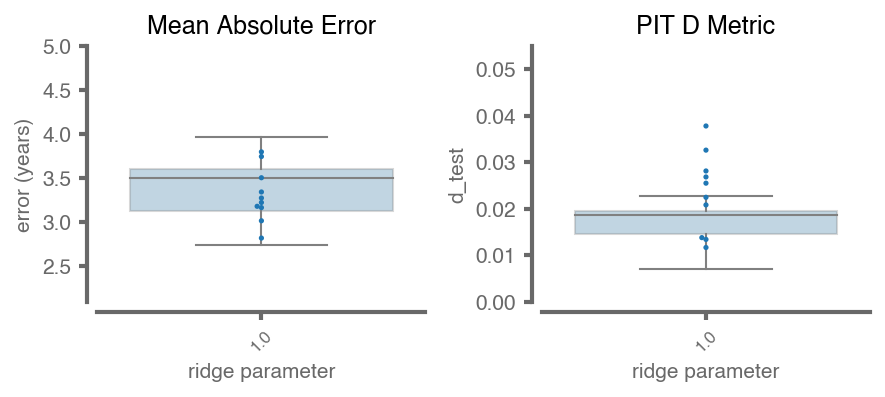

In [7]:
fig, axs = plt.subplots(1,2,figsize=(6,2.75))

ax = axs[0]
sns.boxplot(x="exp_name",
            y="error_val",
            data=df_metrics,
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            whis=100., 
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="error_test",
              data=df_metrics,
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('error (years)')
ax.set_title('Mean Absolute Error')
ax.set_ylim(2.1,5.)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.boxplot(x="exp_name",
            y="d_val",
            data=df_metrics,
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="d_test",
              data=df_metrics,
              size=2.5,
              ax=ax,
            )
ax.set_title('PIT D Metric',fontsize=FS*1.2)
ax.set_ylim(0,.055)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'random_seed_comparison' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()


In [8]:
display(df_metrics[df_metrics["exp_name"]=="exp0"])
display(df_metrics[df_metrics["exp_name"]=="exp3"])

,exp_name,seed,hiddens,ridge_param,error_val,error_test,d_val,d_test


,exp_name,seed,hiddens,ridge_param,error_val,error_test,d_val,d_test
